### Loading necessary library

In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import os, cv2, random

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

import tensorflow as tf
import keras
from keras.models import Sequential, Model
from keras.layers import Dense, Conv2D, MaxPool2D, Flatten, Dropout, MaxPooling2D
from keras.preprocessing.image import ImageDataGenerator
from keras.applications import VGG19, ResNet50
from keras.callbacks import ReduceLROnPlateau



### Loading dataset

In [2]:
data_dir = "/home/hasan/Data Set/flowers"
labels = ['dandelion', 'daisy','tulip','sunflower','rose']
img_size = 224

def get_data(data_dir):
    data = [] 
    for label in labels: 
        path = os.path.join(data_dir, label)
        class_num = labels.index(label)
        for img in os.listdir(path):
            try:
                img_arr = cv2.imread(os.path.join(path, img), cv2.IMREAD_COLOR)
                resized_arr = cv2.resize(img_arr, (img_size, img_size)) # Reshaping images to preferred size
                data.append([resized_arr, class_num])
            except Exception as e:
                print(e)
    return np.array(data)


In [3]:
data = get_data(data_dir)

OpenCV(4.4.0) /tmp/pip-req-build-a98tlsvg/opencv/modules/imgproc/src/resize.cpp:3929: error: (-215:Assertion failed) !ssize.empty() in function 'resize'

OpenCV(4.4.0) /tmp/pip-req-build-a98tlsvg/opencv/modules/imgproc/src/resize.cpp:3929: error: (-215:Assertion failed) !ssize.empty() in function 'resize'

OpenCV(4.4.0) /tmp/pip-req-build-a98tlsvg/opencv/modules/imgproc/src/resize.cpp:3929: error: (-215:Assertion failed) !ssize.empty() in function 'resize'



### Checking dataset is balanced or not

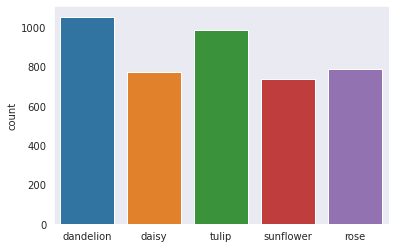

In [4]:
l = []
for i in data:
    l.append(labels[i[1]])
sns.set_style('dark')
sns.countplot(l)

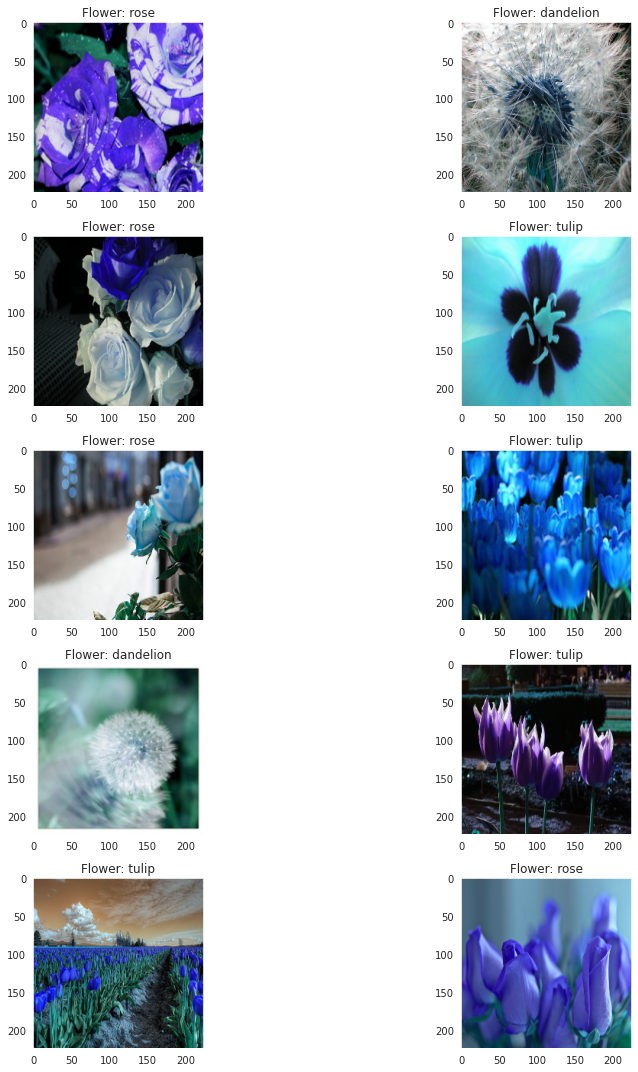

In [5]:
fig,ax=plt.subplots(5,2)
fig.set_size_inches(15,15)
for i in range(5):
    for j in range (2):
        l=random.randint(0,len(data))
        ax[i,j].imshow(data[l][0])
        ax[i,j].set_title('Flower: '+labels[data[l][1]])
        
plt.tight_layout()

### Seperating feature and label data

In [6]:
x = []
y = []

for feature, label in data:
    x.append(feature)
    y.append(label)


In [7]:
len(x)

4323

In [ ]:
# Normalize the data
x = np.array(x) / 255

In [ ]:
# Reshaping the data from 1-D to 3-D as required through input by CNN's 
x = x.reshape(-1, img_size, img_size, 3)
y = np.array(y)


In [ ]:
x_train,x_test,y_train,y_test = train_test_split(x, y, test_size = 0.2, stratify = y, random_state=0)

### Model

In [8]:
pre_trained_model = VGG19(input_shape=(224,224,3), include_top=False, weights="imagenet")

for layer in pre_trained_model.layers[:19]:
        layer.trainable = False

model = Sequential([
    pre_trained_model,
    MaxPool2D((2,2), strides = 2),
    Flatten(),
    Dense(5 , activation='softmax')]
)


80142336/80134624 [==============================] - 27s 0us/step


In [9]:
# Compile the model
model.compile(optimizer="adam", 
               loss='categorical_crossentropy', 
               metrics=['accuracy'])

In [10]:
# Summary of the model
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg19 (Functional)           (None, 7, 7, 512)         20024384  
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 3, 3, 512)         0         
_________________________________________________________________
flatten (Flatten)            (None, 4608)              0         
_________________________________________________________________
dense (Dense)                (None, 5)                 23045     
Total params: 20,047,429
Trainable params: 4,742,661
Non-trainable params: 15,304,768
_________________________________________________________________


In [ ]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', 
                                            patience = 2, 
                                            verbose=1,
                                            factor=0.3, 
                                            min_lr=0.000001
                                           )

In [ ]:
history = model.fit(x_train, y_train, 
                    batch_size = 64, 
                    epochs = 12, 
                    validation_data = (x_test, y_test),
                    callbacks = [learning_rate_reduction]
                   )

### Evaluating

In [ ]:
print("Loss of the model is - " , model.evaluate(x_test,y_test)[0])
print("Accuracy of the model is - " , model.evaluate(x_test,y_test)[1]*100 , "%")

### Accuracy and loss figure

In [ ]:
epochs = [i for i in range(12)]
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
fig.set_size_inches(20,10)

ax[0].plot(epochs , train_acc , 'go-' , label = 'Training Accuracy')
ax[0].plot(epochs , val_acc , 'ro-' , label = 'Testing Accuracy')
ax[0].set_title('Training & Testing Accuracy')
ax[0].legend()
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")

ax[1].plot(epochs , train_loss , 'g-o' , label = 'Training Loss')
ax[1].plot(epochs , val_loss , 'r-o' , label = 'Testing Loss')
ax[1].set_title('Training & Testing Loss')
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Loss")
plt.show()

### predicting with test data

In [ ]:
predictions = model.predict_classes(x_test)
predictions[:5]

In [ ]:
y_test_inv = label_binarizer.inverse_transform(y_test)

### Classification report and confusion matrix

In [ ]:
print(classification_report(y_test_inv, predictions, target_names = labels))

In [ ]:
cm = confusion_matrix(y_test_inv,predictions)
cm

### Heapmap figure

In [ ]:
cm = pd.DataFrame(cm , index = labels , columns = labels)

In [ ]:
plt.figure(figsize = (10,10))
sns.heatmap(cm,cmap= "Blues", linecolor = 'black' , linewidth = 1 , annot = True, fmt='' , xticklabels = labels , yticklabels = labels)


### Seperating correctly classified and incorrectly classified images

In [ ]:
# now storing some properly as well as misclassified indexes'.
i=0
prop_class=[]
mis_class=[]

for i in range(len(y_test_inv)):
    if(y_test_inv[i] == predictions[i]):
        prop_class.append(i)
    if(len(prop_class)==8):
        break

i=0
for i in range(len(y_test_inv)):
    if(y_test_inv[i] != predictions[i]):
        mis_class.append(i)
    if(len(mis_class)==8):
        break

### Correctly classified images

In [ ]:
count=0
fig,ax=plt.subplots(4,2)
fig.set_size_inches(15,15)
for i in range (4):
    for j in range (2):
        ax[i,j].imshow(x_test[prop_class[count]])
        ax[i,j].set_title("Predicted Flower : "+ labels[predictions[prop_class[count]]] +"\n"+"Actual Flower : "+ labels[y_test_inv[prop_class[count]]])
        plt.tight_layout()
        count+=1


### Incorrectly classified images

In [ ]:
count=0
fig,ax=plt.subplots(4,2)
fig.set_size_inches(15,15)
for i in range (4):
    for j in range (2):
        ax[i,j].imshow(x_test[mis_class[count]])
        ax[i,j].set_title("Predicted Flower : "+labels[predictions[mis_class[count]]]+"\n"+"Actual Flower : "+labels[y_test_inv[mis_class[count]]])
        plt.tight_layout()
        count+=1